In [11]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch9 #2 change Jul 30, 2021'

git push origin master

origin	git@github.com:ustchope/dlwpn.git (fetch)
origin	git@github.com:ustchope/dlwpn.git (push)
[master 1dc5825] 更新 ch9 #2 change Jul 30, 2021
 1 file changed, 200 insertions(+), 59 deletions(-)


To github.com:ustchope/dlwpn.git
   5fc3a17..1dc5825  master -> master


In [ ]:
# 自动计算cell的计算时间
%load_ext autotime

#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

In [ ]:
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

# 用于计算机视觉的高级深度学习

> 本章包含

* 计算机视觉的不同分支：图像分类、图像分割、对象检测
* 现代卷积网络架构模式：残差连接、批量归一化、深度可分离卷积
* 可视化和解释卷积神经网络所学内容的技术

前一章通过简单的模型（Conv2D 和 MaxPooling2D 层的堆栈）和一个简单的用例（二值图像分类）首次介绍了计算机视觉的深度学习。 但是计算机视觉不仅仅是图像分类！ 本章深入探讨更多样化的应用程序和高级最佳实践。

## 三个基本的计算机视觉任务

到目前为止，我们一直专注于图像分类模型：输入图像，输出标签。 “这张图片可能包含一只猫，另一张图片可能包含一只狗”。 但图像分类只是深度学习在计算机视觉中的几种可能应用之一。 一般来说，您需要了解三个基本的计算机视觉任务：
* **图像分类**——目标是为图像分配一个或多个标签。 它可以是单标签分类（一幅图像只能属于一个类别而排除其他类别），也可以是多标签分类（标记图像所属的所有类别，如图 9.1 所示）。 例如，当您在 Google 相册应用中搜索关键字时，您在后台查询的是一个非常大的多标签分类模型——该模型具有超过 20,000 个不同的类别，并在数百万张图像上进行训练。
* **图像分割**——目标是将图像“分割”或“划分”成不同的区域，每个区域通常代表一个类别（如图 9.1 所示）。 例如，当 Zoom 或 Google Meet 在视频通话中在您身后显示自定义背景时，它们会使用图像分割模型以像素精度区分您的脸及其背后的内容。
* **对象检测**——目标是在图像中感兴趣的对象周围绘制矩形（称为“边界框”），并将每个矩形与一个类相关联。 例如，自动驾驶汽车可以使用物体检测模型来监控汽车、行人和标志。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsyv8jjfcoj313c0tgtjk.jpg)

除了这三个任务之外，计算机视觉的深度学习还包含一些更小众的任务，例如图像相似性评分（估计两个图像在视觉上的相似程度）、关键点检测（精确定位图像中感兴趣的属性，例如面部特征）、 姿态估计、3D 网格估计等。 但首先，图像分类、图像分割和对象检测构成了每个机器学习工程师都应该熟悉的基础。 大多数计算机视觉应用归结为这三者之一。

您已经在上一章中看到了图像分类的实际应用。 接下来，让我们深入研究图像分割。 这是一项非常有用且用途广泛的技术，您可以使用迄今为止所学的知识直接接触它。

请注意，我们不会涵盖对象检测，因为它对于一本介绍性书籍来说太专业且太复杂。 但是，您可以查看 Keras.io 上的 RetinaNet 示例，该示例展示了如何使用约 450 行代码在 Keras 中从头开始构建和训练异议检测模型。

## 图像分割示例

深度学习的图像分割是关于使用模型为图像中的每个像素分配一个类，从而将图像分割成不同的区域（例如“背景”和“前景”，或“道路”、“汽车”和“ 人行道”）。 这一通用类别的技术可用于为图像和视频编辑、自动驾驶、机器人技术、医学成像等领域的各种有价值的应用提供支持。

您应该了解两种不同风格的图像分割：
1. 语义分割，其中每个像素被独立地分类到一个语义类别中，如“猫”。 如果图像中有两只猫，则相应的像素都映射到相同的通用“猫”类别（见图 9.2）。
2. 实例分割，不仅要按类别对图像像素进行分类，还要解析出单个对象实例。 在其中有两只猫的图像中，实例分割会将“猫 1”和“猫 2”视为两个独立的像素类别（见图 9.2）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsz3v3axnrj31fu0kudn2.jpg)

在这个例子中，我们将专注于语义分割：我们将再次查看猫和狗的图像，这次我们将学习区分主要主题及其背景。

我们将使用 Oxford-IIIT Pets 数据集 (www.robots.ox.ac.uk/~vgg/data/pets/)，其中
包含 7,390 张各种猫狗的图片，以及每张图片的前景-背景“分割蒙版”。 分割掩码是标签的图像分割等价物：它是与输入图像大小相同的图像，具有单个颜色通道，其中每个整数值对应于输入图像中相应像素的类别。 在我们的例子中，我们的分割掩码的像素可以采用三个整数值之一：
* 1（前景）
* 2（背景）
* 3（轮廓）

有关示例，请参见图 9.3。

让我们首先使用 wget和tar shell 实用程序下载和解压缩我们的数据集：

In [4]:
%%bash

cd data

parallel curl -O  ::: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0   238k      0  0:01:18  0:01:18 --:--:--  243k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0   243k      0  0:52:55  0:52:55 --:--:--  247k


In [ ]:
%%bash

cd data

parallel tar -xf :::images.tar.gz annotations.tar.gz

In [5]:
pwd

'/public/huangwei/test/deep-learning-with-python-notebooks'

输入的图片在images/文件夹中保存为JPG文件（如images/Abyssinian_1.jpg），对应的分割掩码保存在annotations/trimaps/文件夹中为同名的PNG文件（如annotations/ trimaps/Abyssinian_1.png）。

让我们准备输入文件路径列表，以及相应的掩码文件路径列表：

In [8]:
import os

input_dir = "data/images/"
target_dir = "data/annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
                          if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [13]:
input_img_paths[:10]

['data/images/Abyssinian_1.jpg',
 'data/images/Abyssinian_10.jpg',
 'data/images/Abyssinian_100.jpg',
 'data/images/Abyssinian_101.jpg',
 'data/images/Abyssinian_102.jpg',
 'data/images/Abyssinian_103.jpg',
 'data/images/Abyssinian_104.jpg',
 'data/images/Abyssinian_105.jpg',
 'data/images/Abyssinian_106.jpg',
 'data/images/Abyssinian_107.jpg']

In [14]:
target_paths[:10]

['data/annotations/trimaps/Abyssinian_1.png',
 'data/annotations/trimaps/Abyssinian_10.png',
 'data/annotations/trimaps/Abyssinian_100.png',
 'data/annotations/trimaps/Abyssinian_101.png',
 'data/annotations/trimaps/Abyssinian_102.png',
 'data/annotations/trimaps/Abyssinian_103.png',
 'data/annotations/trimaps/Abyssinian_104.png',
 'data/annotations/trimaps/Abyssinian_105.png',
 'data/annotations/trimaps/Abyssinian_106.png',
 'data/annotations/trimaps/Abyssinian_107.png']

现在，这些输入之一及其掩码是什么样的？ 让我们快速浏览一下。

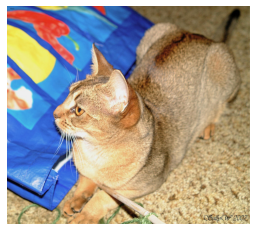

In [9]:
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.axis("off")

plt.imshow(load_img(input_img_paths[9]))

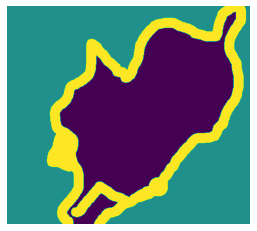

In [10]:
def display_target(target_array):
#     原始标签是 1、2 和 3。我们减去 1，使标签的范围从 0 到 2，
#     然后乘以 127，使标签变为 0（黑色）、127（灰色）、254（接近白色） .
    normalized_array = (target_array.astype("uint8") - 1) * 127 
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    
# 我们使用 color_mode='grayscale' 以便我们加载的图像被视为具有单个颜色通道。
img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) 
display_target(img)

接下来，让我们将输入和目标加载到两个 NumPy 数组中，并将数组拆分为训练集和验证集。 由于数据集非常小，我们可以将所有内容加载到内存中。

In [15]:
import numpy as np
import random

# 我们将所有内容调整为 180x180，就像上一章一样。
img_size = (200, 200) 
# 数据中的样本总数。
num_imgs = len(input_img_paths) 

# 打乱文件路径（它们最初是按品种排序的）。 
# 我们在两个语句中使用相同的种子 (1337) 以确保输入路径和目标路径保持相同的顺序。
random.Random(1337).shuffle(input_img_paths) 
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1  # 减去 1，使我们的标签变为 0、1 和 2。
    return img

# 将 input_imgs float32 数组中的所有图像加载到目标 uint8 数组中（相同顺序）。 
# 输入有 3 个通道（RBG 值），目标有一个通道（包含整数标签）。
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") 
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
    
# 预留 1000 个样本进行验证。
num_val_samples = 1000
# 将数据拆分为训练集和验证集。
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
#     不要忘记将输入图像重新缩放到 [0-1] 范围。
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs) 
    
#     请注意我们如何在任何地方使用 padding="same" 以避免边框填充对特征图大小的影响。
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x) 
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
#     我们以每像素三向 softmax 结束模型，将每个输出像素分类为我们的 3 个类别之一。
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    outputs = layers.Conv2D(3, num_classes, activation="softmax", padding="same")(x) 
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

In [18]:
from tensorflow.keras.utils import plot_model

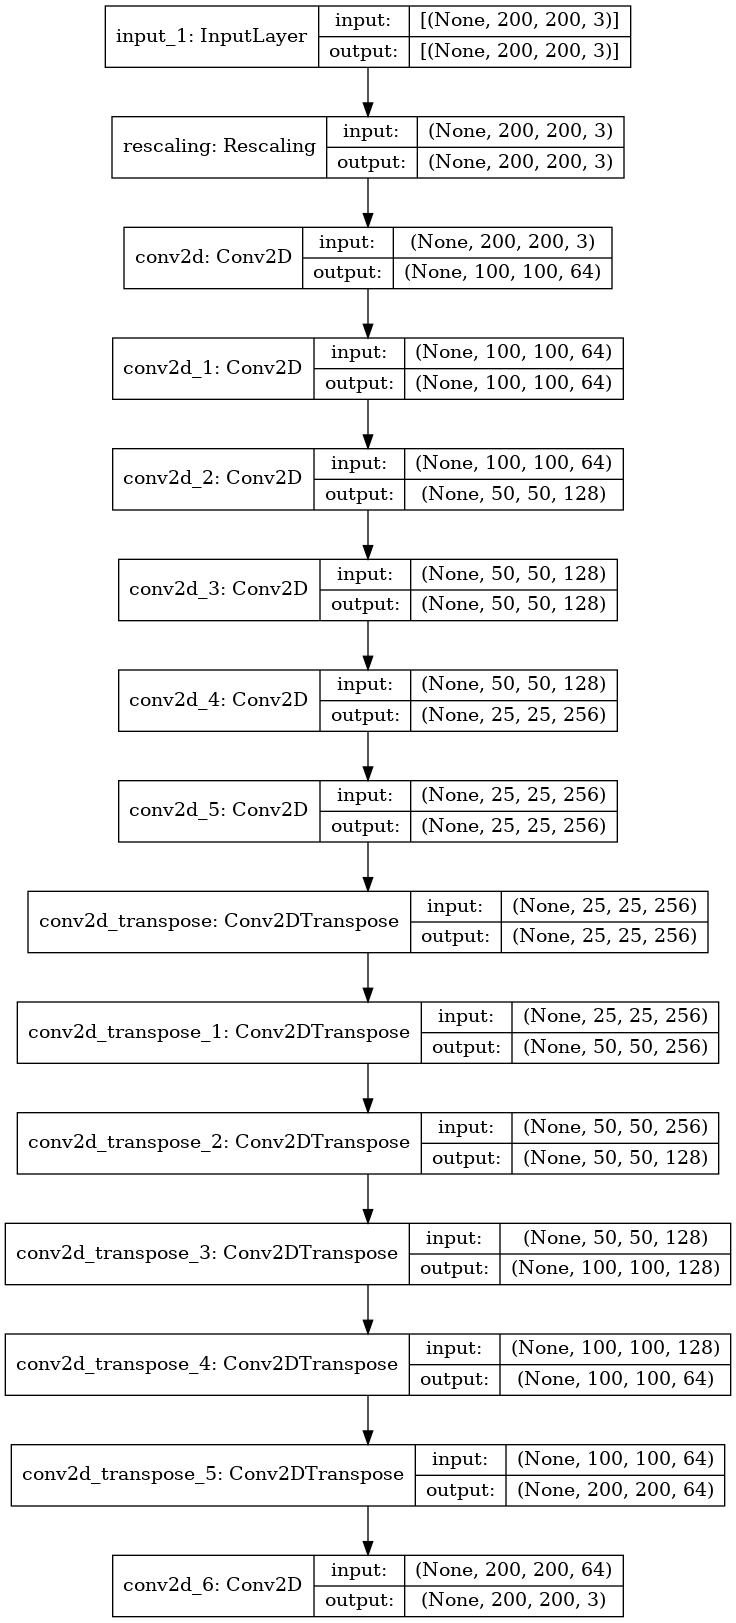

In [20]:
plot_model(model, show_shapes=True)

该模型的前半部分非常类似于您用于图像分类的那种卷积网络：一堆层，过滤器大小逐渐增加。 我们对 Conv2D 的图像进行三次降采样，每次降采样 2 倍——最终激活大小为 (25, 25, 256)。 前半部分的目的是将图像编码为较小的特征图，其中每个空间位置（或“像素”）包含有关原始图像的大空间块的信息。 你可以把它理解为一种压缩。

这个模型的前半部分与您之前看到的分类模型之间的重要区别在于我们进行下采样的方式：在上一章的分类卷积网络中，我们使用 MaxPooling2D 层对特征图进行下采样。在这里，我们通过向每个其他卷积层添加步幅来进行下采样（如果您不记得卷积步幅如何工作的细节，请参阅第 8 章中的“理解卷积步幅”）。我们这样做是因为，在图像分割的情况下，我们非常关心图像中信息的空间位置——因为我们需要生成每像素目标掩码作为模型的输出。当您进行 2x2 最大池化时，您将完全破坏每个池化窗口内的位置信息：您为每个窗口返回一个标量值，而对于该值来自窗口中的 4 个位置中的哪个位置的知识为零。因此，虽然最大池化层在分类任务中表现良好，但对于分割任务来说，它们会对我们造成很大伤害。同时，跨步卷积在保留位置信息的同时，在对特征图进行下采样方面做得更好。在整本书中，你会注意到我们倾向于在任何关心特征位置的模型中使用步幅而不是最大池化——例如第 12 章中的生成模型。

模型的后半部分是一堆 Conv2DTranspose 层。那些是什么？好吧，模型前半部分的输出是形状为 (25, 25, 256) 的特征图，但是我们希望我们最终的输出与目标掩码具有相同的形状，也就是说， (200, 200 , 3)。因此，我们需要应用我们迄今为止应用的一种转换，反转特征映射而不是对它们进行下采样。这就是 Conv2DTranspose 层的上采样目的：您可以将其视为一种学习上采样的卷积层。如果你有一个形状为 (100, 100, 64) 的输入，并且你通过 Conv2D(128, 3, strides=2, padding="same") 层运行它，你会得到一个形状为 (50, 50, 128)。如果通过 Conv2DTranspose(64, 3, strides=2, padding="same") 层运行此输出，您将返回形状为 (100, 100, 64) 的输出，与原始输出相同。因此，在通过一堆 Conv2D 层将我们的输入压缩成形状为 (25, 25, 256) 的特征图之后，我们可以简单地应用相应的 Conv2DTranspose 层序列来返回形状为 (200, 200, 3) 的图像。

我们现在可以编译并拟合我们的模型：

In [21]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)]

history = model.fit(train_input_imgs, 
                    train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 68s 425ms/step - loss: 1.7289 - val_loss: 0.9791
Epoch 2/50
100/100 [==============================] - 35s 345ms/step - loss: 0.8789 - val_loss: 0.7945
Epoch 3/50
100/100 [==============================] - 29s 294ms/step - loss: 0.7955 - val_loss: 0.7552
Epoch 4/50
100/100 [==============================] - 27s 268ms/step - loss: 0.7716 - val_loss: 0.7145
Epoch 5/50
100/100 [==============================] - 25s 247ms/step - loss: 0.7434 - val_loss: 0.6857
Epoch 6/50
100/100 [==============================] - 23s 229ms/step - loss: 0.6946 - val_loss: 0.6894
Epoch 7/50
100/100 [==============================] - 21s 209ms/step - loss: 0.6533 - val_loss: 0.6550
Epoch 8/50
100/100 [==============================] - 19s 188ms/step - loss: 0.6163 - val_loss: 0.6816
Epoch 9/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6014 - val_loss: 0.7340
Epoch 10/50
100/100 [==============================] - 19s 191ms/step - l

让我们展示我们的训练和验证损失：

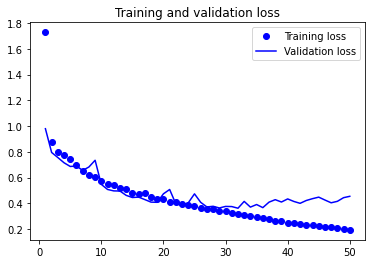

In [22]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

你可以看到我们在中途开始过度拟合，大约在 epoch 25。让我们根据验证精度重新加载我们性能最好的模型，并演示如何使用它来预测分割掩码。

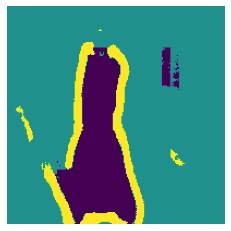

In [23]:
from tensorflow.keras.preprocessing.image import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

# 显示模型预测的实用程序。
def display_mask(pred): 
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
    
display_mask(mask)

我们预测的蒙版中有几个小伪影，是由前景和背景中的几何形状引起的。 尽管如此，我们的模型似乎运行良好。

至此，在第 8 章和第 9 章开头，您已经学习了如何进行图像分类和图像分割的基础知识：您已经可以用您所知道的来完成很多工作。 然而，经验丰富的工程师为解决实际问题而开发的 convnets 并不像我们迄今为止在演示中使用的那么简单。 您仍然缺乏必要的心理模型和思维过程，使专家能够快速准确地决定如何组合最先进的模型。 为了弥补这一差距，您需要了解架构模式。 让我们深入了解。

## 现代 convnet 架构模式

模型的“架构”是创建它的所有选择的总和：使用哪些层、如何配置它们、以何种方式连接它们。 这些选择定义了模型的假设空间：梯度下降可以搜索的可能函数的空间，由模型的权重参数化。 与特征工程一样，一个好的假设空间会编码您手头问题及其解决方案的先验知识。 例如，使用卷积层意味着您事先知道输入图像中存在的相关模式是平移不变的。 为了有效地从数据中学习，你需要对你正在寻找的东西做出假设。

模型架构通常是成功与失败之间的区别。 如果您做出不适当的架构选择，您的模型可能会陷入次优指标，而且再多的训练数据也无法挽救它。 相反，良好的模型架构将加速学习并使您的模型能够有效利用可用的训练数据，从而减少对大型数据集的需求。 一个好的模型架构可以减少搜索空间的大小，或者更容易收敛到搜索空间的一个好的点。 就像特征工程和数据管理一样，模型架构就是让梯度下降更容易解决问题——并且记住梯度下降是一个非常愚蠢的搜索过程，所以它需要它可以获得的所有帮助。

模型架构与其说是一门科学，不如说是一门艺术。 经验丰富的机器学习工程师能够在第一次尝试时凭直觉拼凑出高性能模型，而初学者通常很难创建一个完全可以训练的模型。 这里的关键词是：没有人能凭直觉给你一个清晰的解释，什么有效，什么无效。 专家依赖模式匹配，这是他们通过丰富的实践经验获得的能力。 您将在本书中发展自己的直觉。 然而，这也与直觉无关——实际科学的方式并不多，但就像在任何工程学科中一样，有最佳实践。

在接下来的部分中，我们将回顾一些基本的 convnet 架构最佳实践，特别是残差连接、批量归一化和可分离卷积。 一旦掌握了如何使用它们，您将能够构建高效的图像模型。 我们将演示如何将它们应用于我们的猫与狗分类问题。

让我们从鸟瞰开始：系统架构的模块化-层次-重用（MHR）公式。

### 模块化、层次结构和重用

如果你想让一个复杂的系统更简单，你可以应用一个通用的方法：只需将复杂的无定形汤结构化为 ，将模块组织成模块层次结构重用 ，并在适当的多个位置启动相同的模块（“重用” 是另一个词）。 这就是 MHR 公式（模块化-层次结构-重用），它的抽象是几乎所有使用“架构”一词的领域的系统架构的基础。 它是任何有意义的复杂系统的组织的核心，无论是大教堂、您自己的身体、美国海军还是 Keras 代码库。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gszy6y0io2j30zg0ta7e8.jpg)

如果您是一名软件工程师，您已经非常熟悉这些原则：有效的代码库是模块化的、分层的，并且您不会两次重新实现同一件事，而是依赖于可重用的类和函数。 如果你遵循这些原则来考虑你的代码，你可以说你在做“软件架构”。

深度学习本身只是将这个配方应用到通过梯度下降进行连续优化：您采用经典的优化技术（连续函数空间上的梯度下降），并将搜索空间构建为模块（层），组织成一个深层层次结构 （通常只是一个堆栈，最简单的层次结构），您可以在其中重用任何可能的东西（例如，卷积都是关于在不同的空间位置重用相同的信息）。

同样，深度学习模型架构主要是巧妙地利用模块化、层次结构和重用。 您会注意到，所有流行的 convnet 架构不仅结构化为层，而且结构化为重复的层组（称为“块”或“模块”）。 例如，我们在上一章中使用的流行 VGG16 架构被构造成重复的“conv - conv - max pooling”块（见图 9.8）。

此外，大多数 convnets 通常具有金字塔状结构（特征层次结构）。 回想一下，例如，我们在上一章构建的第一个卷积网络中使用的卷积过滤器数量的变化：32、64、128。过滤器的数量随着层深度的增加而增加，而特征图的大小相应地缩小 . 您会在 VGG16 模型的块中注意到相同的模式（见图 9.8）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gszy9y6dmbj318e0qadje.jpg)

更深的层次结构本质上是好的，因为它们鼓励特征重用，因此也鼓励抽象。 一般来说，窄层的深堆叠比大层的浅堆叠性能更好。 但是，堆叠层的深度是有限制的：梯度消失的问题。 这将我们引向我们的第一个基本模型架构模式：残差连接。

> **论消融研究在深度学习研究中的重要性**  
> 深度学习架构通常不仅仅是设计出来的——它们是通过反复尝试和选择似乎有效的方法而发展起来的。 就像在生物系统中一样，如果您采用任何复杂的实验性深度学习设置，您很可能可以在不损失性能的情况下删除一些模块（或用随机模块替换一些经过训练的功能）。  
>
> 深度学习研究人员面临的激励使情况变得更糟：通过使系统变得比必要的复杂，他们可以使它看起来更有趣或更新颖，从而增加他们通过同行评审过程获得论文的机会。 如果您阅读了大量深度学习论文，您会注意到它们通常在风格和内容上针对同行评审进行了优化，这些方式会积极损害解释的清晰度和结果的可靠性。 例如，深度学习论文中的数学很少用于明确形式化概念或推导出不明显的结果——相反，它被用作严肃的信号，就像推销员穿着昂贵的西装一样。
>
> 研究的目标不应该仅仅是发表，而是产生可靠的知识，理解因果关系。 至关重要的是，在您的系统中是生成可靠知识的最直接方式。 研究因果关系有一种非常省力的方法：消融研究。 消融研究包括系统地尝试移除系统的某些部分——使其更简单——以确定其性能的实际来源。 如果你发现 X + Y + Z 给你很好的结果，也试试 X、Y、Z、X + Y、X + Z、Y + Z，看看会发生什么。
>
> 如果您成为一名深度学习研究人员，请消除研究过程中的噪音：对您的模型进行消融研究。 总是问：“能不能有一个更简单的解释？这种增加的复杂性真的有必要吗？为什么？”

### 残差连接

您可能知道电话游戏，在英国也称为中国耳语，在法国也称为 téléphone arabe，在这种游戏中，最初的信息在玩家耳边耳语，然后在下一位玩家耳边耳语，等等 . 最终的消息最终与其原始版本几乎没有相似之处。 这是一个有趣的比喻，用于在嘈杂的信道上顺序传输中发生的累积错误。

碰巧的是，顺序深度学习模型中的反向传播与电话游戏非常相似。 您有一系列函数，如下所示：
```
y = f4(f3(f2(f1(x))))
```

游戏的名称是根据f4的输出记录的错误（模型的损失）调整每个函数的参数。 要调整 f1，您需要通过 f2、f3 和 f4 渗透误差信息。 但是，链中的每个连续函数都会在此过程中引入一些噪声。 如果你的函数链太深，这种噪音就会开始淹没梯度信息，反向传播就会停止工作。 你的模型根本不会训练。 这称为梯度消失问题。

修复方法很简单：只需强制链中的每个函数都是非破坏性的——保留包含在先前输入中的信息的无噪声版本。 实现这一点的最简单方法称为残差连接。 这很简单：只需将一个层或层块的输入添加回其输出（见图 9.9）。 残差连接充当破坏性或嘈杂块（例如包含 ReLU 激活或
dropout 层），使来自早期层的误差梯度信息能够通过深层网络无噪声地传播。 该技术于 2015 年与 ResNet 系列模型（由 He 等人在 Microsoft 开发）一起引入。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gszyn03bnoj30va0mmwf8.jpg)

在实践中，你会实现一个像这样的残差连接：
``` Python
# 一些输入张量。
x = ... 
# 保存指向原始输入的指针。 这被称为“残差”。
residual = x 
# 这个计算块可能是破坏性的或嘈杂的，这很好。
x = block(x) 
# 将原始输入添加到层的输出：因此最终输出将始终保留有关原始输入的完整信息。
x = add([x, residual])
```

请注意，将输入添加回块的输出意味着输出应与输入具有相同的形状。 请注意，如果您的块包含具有更多过滤器或最大池化层的卷积层，则情况并非如此。 在这种情况下，使用没有激活的 1x1 Conv2D 层将残差线性投影到所需的输出形状。 您通常会在目标块的卷积层中使用 padding="same" 以避免由于填充导致的空间下采样，并且您会在残差投影中使用步幅来匹配由最大池化层引起的任何下采样。

> 清单 9.2 目标块改变输出过滤器数量的情况

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)

# 把残差放在一边。
residual = x 

# 这是我们在其周围创建残差连接的层：它将输出过滤器的数量从 32 增加到 64。
# 请注意，我们使用 padding="same" 以避免由于填充而下采样。
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) 

# 残差只有 32 个过滤器，因此我们使用 1x1 将其投影到正确的 Conv2D 形状。
residual = layers.Conv2D(64, 1)(residual) 

# 现在块输出和残差具有相同的形状并且可以添加。
x = layers.add([x, residual])

model = keras.Model(inputs= inputs, outputs=x)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 30, 30, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 30, 30, 64)   18496       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 30, 30, 64)   2112        conv2d_16[0][0]                  
____________________________________________________________________________________________

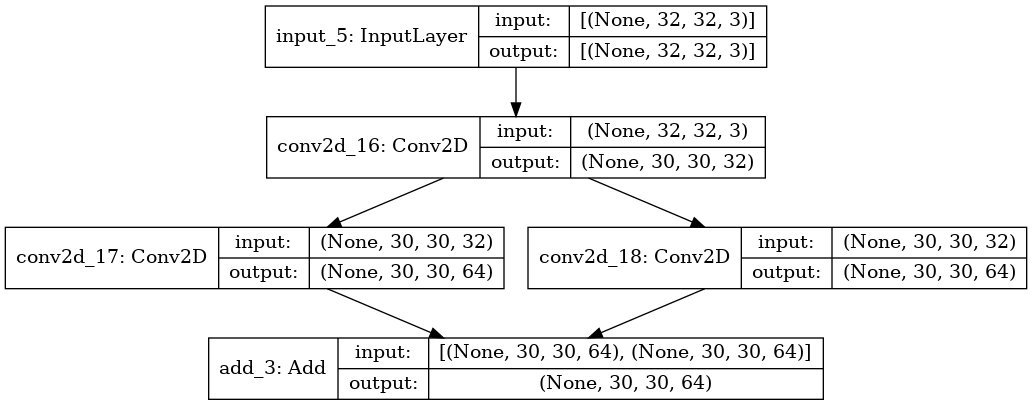

In [31]:
plot_model(model, show_shapes=True)

> 清单 9.3 目标块包含最大池化层的情况

In [32]:
inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, 3, activation="relu")(inputs)

# 把残差放在一边。
residual = x 

# 这是我们在其周围创建残差连接的两层块：它包括一个 2x2 最大池化层。 
# 请注意，我们在卷积层和最大池化层中都使用 padding="same" 以避免由于填充而下采样。
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) 
x = layers.MaxPooling2D(2, padding="same")(x) 

# 我们在残差投影中使用最大池化层匹配下采样创建的strides=2。
residual = layers.Conv2D(64, 1, strides=2)(residual) 

# 现在块输出和残差具有相同的形状并且可以添加。
x = layers.add([x, residual])

model = keras.Model(inputs= inputs, outputs=x)

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 30, 30, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 30, 30, 64)   18496       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 15, 15, 64)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

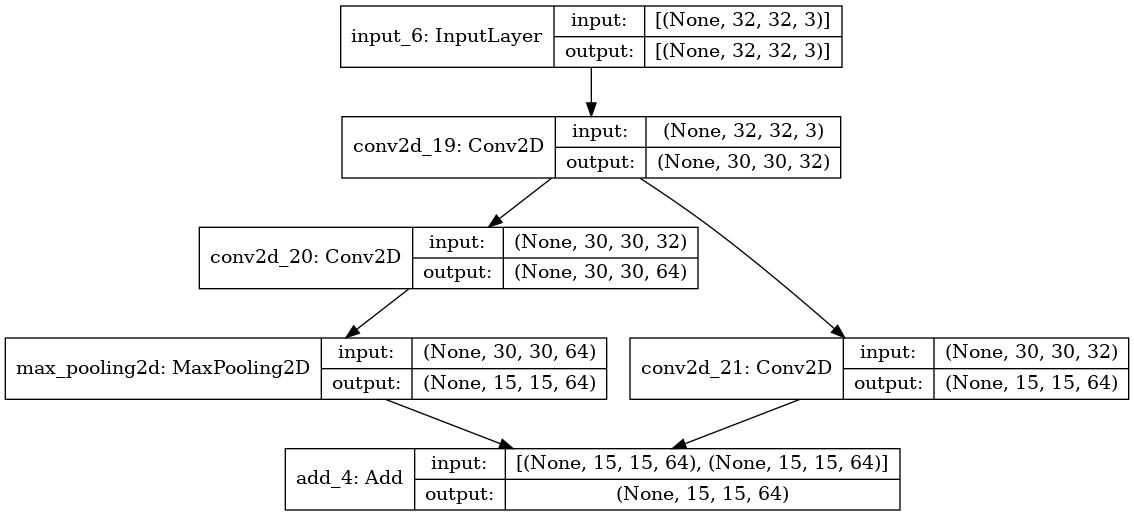

In [34]:
plot_model(model, show_shapes=True)

为了使这些想法更具体，这里有一个简单的卷积网络示例，它由一系列块组成，每个块由两个卷积层和一个可选的最大池化层组成，每个块周围都有一个残差连接：

In [35]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 应用具有残差连接的卷积块的实用函数，可以选择添加最大池化。
def residual_block(x, filters, pooling=False): 
    
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
#         如果我们使用最大池化，我们会添加一个跨步卷积来将残差投影到预期的形状。
        residual = layers.Conv2D(filters, 1, strides=2)(residual) 
    elif filters != residual.shape[-1]:
#         如果我们不使用最大池化，我们只会在通道数量发生变化时投影残差。
        residual = layers.Conv2D(filters, 1)(residual) 
    
    x = layers.add([x, residual])
    return x

# 第一个块。
x = residual_block(x, filters=32, pooling=True) 
# 第二块。 注意每个块中增加的过滤器计数。
x = residual_block(x, filters=64, pooling=True) 
# 最后一个块不需要最大池化层，因为我们将在它之后立即应用全局平均池化。
x = residual_block(x, filters=128, pooling=False) 

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 32)   896         rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_22[0][0]                  
____________________________________________________________________________________________

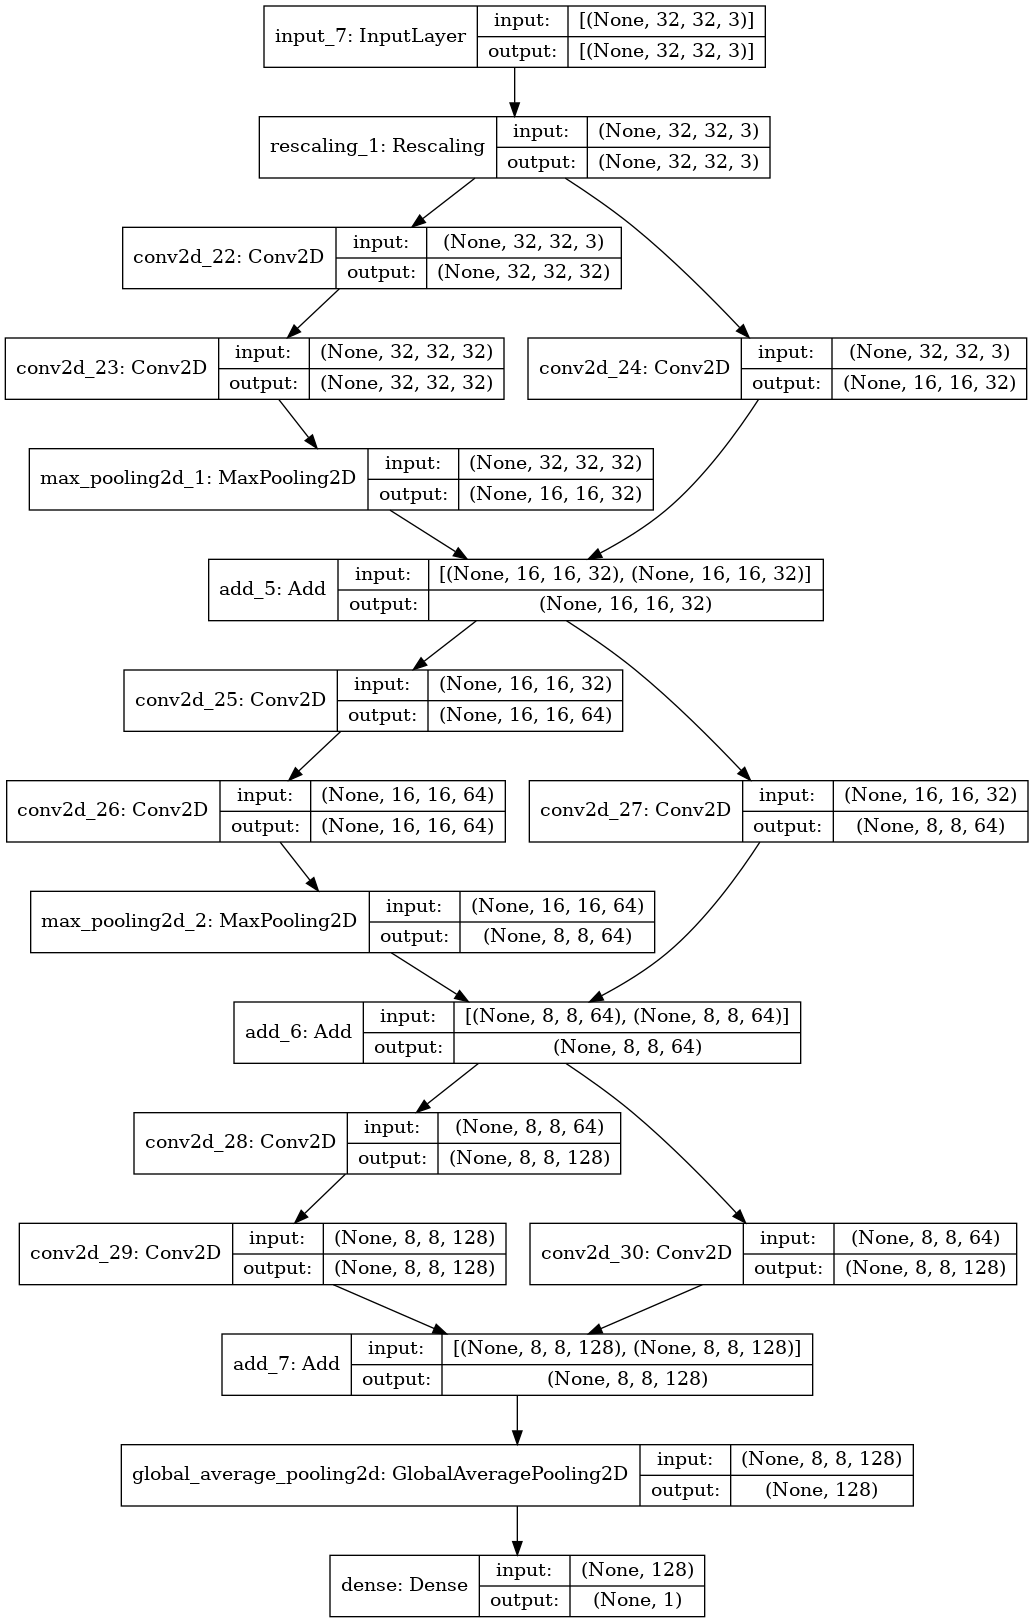

In [36]:
plot_model(model, show_shapes=True)

使用残差连接，您可以构建任意深度的网络，而不必担心梯度消失。 现在，让我们继续下一个基本的 convnet 架构模式：批量归一化。

### 批量归一化

归一化是一大类方法，旨在使机器学习模型看到的不同样本彼此更加相似，这有助于模型学习并很好地推广到新数据。 最常见的数据归一化形式是您在本书中已经见过多次的形式：通过从数据中减去均值使数据以零为中心，并通过将数据除以其标准偏差来给数据一个单位标准偏差。 实际上，这假设数据遵循正态（或高斯）分布，并确保该分布居中并缩放到单位方差：
```
normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)
```